This lesson was adapted from the end of [lesson 3](https://course.fast.ai/videos/?lesson=3) and beginning of [lesson 4](https://course.fast.ai/videos/?lesson=4) of the latest fast.ai Practical Deep Learning for Coders course.  We will cover all the material you need here in this notebook, so no need to have taken the Deep Learning course.  Even if you have taken the DL class, we will go slower and get into more detail here!

# Language Modeling & Sentiment Analysis of IMDB movie reviews

We will be looking at IMDB movie reviews.  We want to determine if a review is negative or positive, based on the text.  In order to do this, we will be using **transfer learning**.

Transfer learning has been widely used with great success in computer vision for several years, but only in the last year or so has it been successfully applied to NLP (beginning with ULMFit, which we will use here, which was built upon by BERT and GPT-2).

As Sebastian Ruder wrote in [The Gradient](https://thegradient.pub/) last summer, [NLP's ImageNet moment has arrived](https://thegradient.pub/nlp-imagenet/).

## Language Models

Language modeling can be a fun creative form. Research scientist [Janelle Shane blogs](https://aiweirdness.com/) & [tweets](https://twitter.com/JanelleCShane) about her creative AI explorations, which often involve text.  For instance, see her:

- [Why did the neural network cross the road?](https://aiweirdness.com/post/174691534037/why-did-the-neural-network-cross-the-road)
- [Try these neural network-generated recipes at your own risk.](https://aiweirdness.com/post/163878889437/try-these-neural-network-generated-recipes-at-your)
- [D&D character bios - now making slightly more sense](https://aiweirdness.com/post/183471928977/dd-character-bios-now-making-slightly-more)

## Using a GPU

You will need to have the fastai library installed for this lesson, and you will want to use a GPU to train your neural net.  If you don't have a GPU you can use in your computer (currently, only Nvidia GPUs are fully supported by the main deep learning libraries), no worries!  There are a number of cloud options you can consider:

[GPU Cloud Options](https://course.fast.ai/#using-a-gpu)

**Reminder: If you are using a cloud GPU, always be sure to shut it down when you are done!!! Otherwise, you could end up with an expensive bill!**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
# import fastai.utils.collect_env

# fastai.utils.collect_env.show_install()

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [4]:
# bs=48
# bs=24
bs=192

In [5]:
torch.cuda.set_device(2)

## Preparing the data (on a sample)

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [5]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/jhoward/.fastai/data/imdb_sample/data_lm_export.pkl'),
 PosixPath('/home/jhoward/.fastai/data/imdb_sample/data_clas_export.pkl'),
 PosixPath('/home/jhoward/.fastai/data/imdb_sample/models'),
 PosixPath('/home/jhoward/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [7]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [8]:
data_lm.train_ds[0][0]

Text xxbos i remember when i first saw this short , i was really laughing so hard , that like with a lot of other films that i have seen , no sound came out ! xxmaj curly is really great at " singing " opera in this one , i am surprised that he did not consider a career as a professional singer , because he was really good ! 
 
  xxmaj if you noticed , this was filmed near the end of xxmaj curly 's career as a xxmaj xxunk , you could really tell he had changed , because he had lost weight and was xxunk , his voice was xxunk , his face was getting lined with wrinkles , though he still could pull it off , he looked like he was fifty at the age of forty . xxmaj this was because he was suffering many minor strokes before his big one that ended his career . xxmaj be he still managed to pull it off in his last ones ! 
 
  xxmaj if you do n't mind the fact that xxmaj curly was really getting very ill at this point , this is actually one of their funniest xxunk . i know that i did n't mind the

But the underlying data is all numbers

In [9]:
data_lm.train_ds[0][0].data[:10]

array([  2,  19, 428,  73,  19, 105, 239,  20, 460,  11])

### Alternative apporach: with the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [10]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

Now let's grab the full dataset for what follows.

In [6]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/README'),
 PosixPath('/home/jhoward/.fastai/data/imdb/lm_databunch_bwd'),
 PosixPath('/home/jhoward/.fastai/data/imdb/test'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/jhoward/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jhoward/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/jhoward/.fastai/data/imdb/models'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jhoward/.fastai/data/imdb/imdb_textlist_class'),
 PosixPath('/home/jhoward/.fastai/data/imdb/unsup'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train')]

In [7]:
(path/'train').ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/neg'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/pos')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

### More about WikiText-103

We will be using the [WikiText-103](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) dataset created by [Stephen Merity](https://smerity.com/) to pre-train a language model.

To quote [Stephen's post](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/):

*The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia. The dataset is available under the Creative Commons Attribution-ShareAlike License.*

*Compared to the preprocessed version of Penn Treebank (PTB), WikiText-2 is over 2 times larger and WikiText-103 is over 110 times larger. The WikiText dataset also features a far larger vocabulary and retains the original case, punctuation and numbers - all of which are removed in PTB. As it is composed of full articles, the dataset is well suited for models that can take advantage of long term dependencies.*

### Creating the TextLMDataBunch

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [11]:
path.ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/README'),
 PosixPath('/home/jhoward/.fastai/data/imdb/lm_databunch_bwd'),
 PosixPath('/home/jhoward/.fastai/data/imdb/test'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/jhoward/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jhoward/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/jhoward/.fastai/data/imdb/models'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jhoward/.fastai/data/imdb/imdb_textlist_class'),
 PosixPath('/home/jhoward/.fastai/data/imdb/unsup'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train')]

In [7]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1, seed=42)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs, num_workers=1))

In [9]:
len(data_lm.vocab.itos),len(data_lm.train_ds)

(60004, 90000)

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [13]:
data_lm.show_batch()

idx,text
0,"xxmaj xxunk are too busy dealing with the fairly uninteresting lives of xxmaj stan and xxmaj daniel rather than focusing on xxmaj richie . xxmaj one flashback in a music store , where xxmaj richie has a crush on an employee stands out and really shows the viewer where this film could have gone . xxmaj but in the end , not much . xxmaj two many drawn out scenes"
1,"guy . i mean , xxup how bad can a xxup bad guy xxup be ? ( xxmaj ask xxmaj richard xxmaj johnson ) . xxmaj joseph xxmaj cotten tries hard not to look embarrassed as he staggers through his cameo appearance . xxmaj in the name of all that 's holy , do n't rent this darned bomb . xxbos xxmaj this is quite possibly the worst sequel ever"
2,"made to appeal to the type of person who 's willing to kneel at the alter of either firemen specifically , "" xxmaj heroes "" or gods in general , i suppose . i just do n't have enough bad things to say about this film . xxmaj it could n't have been cheap , either , with all the stars that were in it plus all those special effects"
3,", this performance reminds me of the man xxmaj maurice xxmaj xxunk played in xxup gigi ( but without the xxunk cute older man who loves the ladies . i strongly doubt the real - life xxmaj marquis de xxmaj sade would have recognized this character at all ! \n \n xxmaj the film , surprisingly , does n't have a lot of nudity , though what it does"
4,"even his friend gives money to his father , but the butterfly effect completely fails to return to its cause . \n \n xxmaj this is a very dark film as each character that gets affected , suffers never ending depression . xxmaj none of the normal avenues for relief seem to be effective and the only thing the authorities seem to do is give out quantities of stress"


Let's save our databunch for next time:

In [14]:
data_lm.save('lm_databunch')

### Loading saved data, and creating the language model

In the future we can load the data:

In [7]:
data_lm = load_data(path, 'lm_databunch', bs=bs)

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [8]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [9]:
wiki_itos = pickle.load(open(Config().model_path()/'wt103-1/itos_wt103.pkl', 'rb'))

In [19]:
wiki_itos[:10]

['xxunk', 'xxpad', 'xxmaj', 'the', ',', '.', 'of', 'and', 'in', 'to']

In [20]:
vocab = data_lm.vocab

In [21]:
vocab.stoi["stingray"]

30136

In [22]:
vocab.itos[vocab.stoi["stingray"]]

'stingray'

In [23]:
vocab.itos[vocab.stoi["mobula"]]

'xxunk'

In [24]:
awd = learn_lm.model[0]

In [25]:
from scipy.spatial.distance import cosine as dist

In [26]:
enc = learn_lm.model[0].encoder

In [27]:
enc.weight.size()

torch.Size([49906, 400])

### Difference in vocabulary between IMDB and Wikipedia

We are going to load wiki_itos, which can be downloaded along with wikitext-103.  We will compare the vocabulary from wikitext with the vocabulary in IMDB.  It is to be expected that the two sets have some different vocabulary words, and that is no problem for transfer learning!

In [28]:
len(wiki_itos)

60001

In [29]:
len(vocab.itos)

49906

In [30]:
i, unks = 0, []
while len(unks) < 50:
    if data_lm.vocab.itos[i] not in wiki_itos: unks.append((i,data_lm.vocab.itos[i]))
    i += 1

In [31]:
wiki_words = set(wiki_itos)

In [32]:
imdb_words = set(vocab.itos)

In [33]:
wiki_not_imbdb = wiki_words.difference(imdb_words)

In [34]:
imdb_not_wiki = imdb_words.difference(wiki_words)

In [35]:
wiki_not_imdb_list = []

for i in range(100):
    word = wiki_not_imbdb.pop()
    wiki_not_imdb_list.append(word)
    wiki_not_imbdb.add(word)

In [36]:
wiki_not_imdb_list[:15]

['49ers',
 'bans',
 'christianization',
 'severin',
 'binaural',
 '91st',
 'graphite',
 'campaigners',
 'phaser',
 'polynomial',
 'diamandis',
 '384',
 'irritability',
 'crenellated',
 'plenipotentiary']

In [37]:
imdb_not_wiki_list = []

for i in range(100):
    word = imdb_not_wiki.pop()
    imdb_not_wiki_list.append(word)
    imdb_not_wiki.add(word)

In [38]:
imdb_not_wiki_list[:15]

['mannerist',
 'mihic',
 'drea',
 "d'arcy",
 'hohl',
 'be-',
 'castorini',
 'cuties',
 'solondz',
 'upends',
 'babbar',
 'heero',
 'pronouncement',
 'starrett',
 'hocus']

All words that appear in the IMDB vocab, but not the wikitext-103 vocab, will be initialized to the same random vector in a model.  As the model trains, we will learn these weights.

In [39]:
vocab.stoi["modernisation"]

0

In [40]:
"modernisation" in wiki_words

True

In [41]:
vocab.stoi["30-something"]

24319

In [42]:
"30-something" in wiki_words, "30-something" in imdb_words

(False, True)

In [43]:
vocab.stoi["linklater"]

18065

In [44]:
"linklater" in wiki_words, "linklater" in imdb_words

(False, True)

In [45]:
"house" in wiki_words, "house" in imdb_words

(True, True)

In [46]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], 
            enc.weight[vocab.stoi["linklater"], :])

True

In [47]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], 
            enc.weight[vocab.stoi["house"], :])

False

In [48]:
new_word_vec = enc.weight[vocab.stoi["linklater"], :]

### Generating fake movie reviews (using wiki-text model)

In [49]:
TEXT = "The color of the sky is"
N_WORDS = 40
N_SENTENCES = 2

In [50]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The color of the sky is often Black in color , and the color is as black as white . 
 
  = = History = = 
 
  The Black Hills of New York City , in 1911 ,
The color of the sky is the Blue Betty , a double - as in English and Italian , and the Latin word for " grey " in English . 
 
  = = = Philosophy = = = 
 
 


In [51]:
TEXT = "I hated this movie"
N_WORDS = 30
N_SENTENCES = 2

In [52]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie . The German language magazine Die Saturday News ( German ) , writing on the themes of the German Jews , wrote
I hated this movie The Devil Wears Prada . 
 
  = = = Cultural references = = = 
 
  The film opens with the film Wounded


In [53]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie , but rather " in the same way " , and when he heard Hugh Grant discussing the influences he found , he was " very strong about
I hated this movie , but after seeing the film The Lord of the Rings , they decided to shoot it in Heaven . 
 
  = = Production =


In [54]:
doc(LanguageLearner.predict)

Lowering `temperature` will make the texts less randomized.

In [55]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

I hated this movie , but it was a popular film . The film was released on DVD in November 2006 . The film was released on DVD and
I hated this movie , but the film was a commercial success . It was released on DVD in September 2005 . 
 
  = = = Critical reception = =


In [56]:
doc(LanguageLearner.predict)

In [57]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

I hated this movie , but the film was a commercial success . The film was released on DVD and Blu - ray in November 2008 . The film
I hated this movie , but the film was shot in Los Angeles , California . The film was released on September 15 , 2006 , and was released


### Training the model

Now, we want to choose a good learning rate.

In [96]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


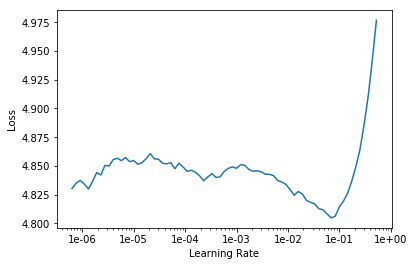

In [97]:
learn_lm.recorder.plot(skip_end=15)

In [9]:
lr = 1e-3
lr *= bs/48

In [10]:
learn_lm.to_fp16();

In [17]:
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.102362,3.967245,0.296941,15:21


Since this is relatively slow to train, we will save our weights:

In [18]:
learn_lm.save('fit_1')

In [11]:
learn_lm.load('fit_1');

To complete the fine-tuning, we can then unfreeze and launch a new training.

In [12]:
learn_lm.unfreeze()

In [13]:
learn_lm.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.872039,3.803822,0.315553,16:43
1,3.794908,3.739284,0.321787,17:01
2,3.736880,3.705275,0.325063,17:01
3,3.673460,3.661957,0.329320,17:03
4,3.613378,3.630191,0.333327,17:01
5,3.531500,3.602567,0.336381,17:02
6,3.458650,3.574097,0.340086,17:01
7,3.365858,3.561914,0.341489,17:01
8,3.288830,3.558446,0.342408,17:02
9,3.250091,3.561159,0.342382,17:03


In [14]:
learn_lm.save('fine_tuned')

We have to save not just the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [16]:
learn_lm.save_encoder('fine_tuned_enc')

### Loading our saved weights

In [22]:
learn_lm.load('fine_tuned');

Now that we've trained our model, different representations have been learned for the words that were in IMDB but not wiki (remember that at the beginning we had initialized them all to the same thing):

In [23]:
enc = learn_lm.model[0].encoder

In [112]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], 
            enc.weight[vocab.stoi["linklater"], :])

False

In [113]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], new_word_vec)

False

### More generated movie reviews

How good is our model? Well let's try to see what it predicts after a few given words.

In [17]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [18]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because it was about Jack the Ripper and his family and friends . This was a good movie , but not as touching , when it was over . The friends ( who were great in their
i liked this movie because of the very good performances of Sandra Bullock . She has the nice - looking look and personality of Sandra Bullock . Sandra Bullock is hopeless as the little girl who grew up


In [19]:
TEXT = "This movie was"
N_WORDS = 30
N_SENTENCES = 2

In [20]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie was ... awful . The plot was groundbreaking , the cinematography was alright , but the acting was terrible . The acting was pathetic . The story was
This movie was so bad i had to fast forward through most of it . My friends and i are talking about movies that are so bad they 're good . i


In [21]:
TEXT = "I hated this movie"
N_WORDS = 40
N_SENTENCES = 2

In [22]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie . Just watch it and you 'll know who was better . The Architect , i think , was an idiot , and the whole movie was a waste of time . i found it interesting ,
I hated this movie . i watched it with a friend , and after watching it i was constantly looking at the cover of the film , thinking , " This is a great movie , not a Blockbuster " , but


### Risks of language models

We will talk about ethical concerns raised by very accurate language models in lesson 7, but here are a few brief notes:

In reference to [OpenAI's GPT-2](https://www.theverge.com/2019/2/14/18224704/ai-machine-learning-language-models-read-write-openai-gpt2): Jeremy Howard said, *I’ve been trying to warn people about this for a while. We have the technology to totally fill Twitter, email, and the web up with reasonable-sounding, context-appropriate prose, which would drown out all other speech and be impossible to filter.*

For a small example, consider when completely incorrect (but reasonable sounding) ML generated answers were [posted to StackOverflow](https://meta.stackoverflow.com/questions/384596/completely-incorrect-machine-learning-generated-answers?stw=2):

<img src="images/robot-overflow.png" alt="Roboflow" style="width: 80%"/>

<img src="images/husain-tweet.png" alt="Roboflow" style="width: 60%"/>

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [8]:
bs=48

In [9]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs, num_workers=1))

In [11]:
data_clas.save('imdb_textlist_class')

In [9]:
data_clas = load_data(path, 'imdb_textlist_class', bs=bs, num_workers=1)

In [10]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj by now you 've probably heard a bit about the new xxmaj disney dub of xxmaj miyazaki 's classic film , xxmaj laputa : xxmaj castle xxmaj in xxmaj the xxmaj sky . xxmaj during late summer of 1998 , xxmaj disney released "" xxmaj kiki 's xxmaj delivery xxmaj service "" on video which included a preview of the xxmaj laputa dub saying it was due out",pos
"xxbos 8 xxmaj simple xxmaj rules for xxmaj dating xxmaj my xxmaj teenage xxmaj daughter had an auspicious start . xxmaj the supremely - talented xxmaj tom xxmaj shadyac was involved in the project . xxmaj this meant that the comedy would be nothing less of spectacular , and that 's exactly what happened : the show remains one of the freshest , funniest , wittiest shows made in a",pos
"xxbos i have n't liked many xxup tv shows post 1990 , but xxup that xxup 70s xxup show is great . xxmaj never seeing it during it 's first run , thinking a gimmicky period piece , i was wrong ! i started watching in reruns and the more i watched , the more i liked ! xxmaj now , it is the only show xxunk xxunk that i",pos
"xxbos * xxmaj some spoilers * \n \n xxmaj this movie is sometimes subtitled "" xxmaj life xxmaj everlasting . "" xxmaj that 's often taken as reference to the final scene , but more accurately describes how dead and buried this once - estimable series is after this sloppy and illogical send - off . \n \n xxmaj there 's a "" hey kids , let 's",neg


We can then create a model to classify those reviews and load the encoder we saved before.

In [20]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3) #.to_fp16()
learn_c.load_encoder('fine_tuned_enc')
learn_c.freeze()

In [11]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


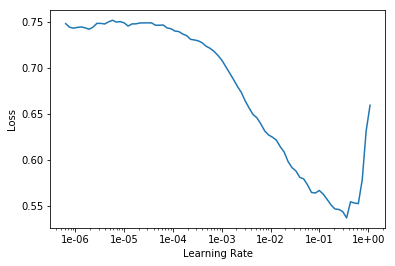

In [123]:
learn_c.recorder.plot()

In [21]:
learn_c.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.246133,0.182420,0.931400,03:39


In [22]:
learn_c.save('first')

In [ ]:
learn_c.load('first');

In [23]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.226397,0.164568,0.938320,04:02


In [24]:
learn_c.save('2nd')

In [25]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.181977,0.159952,0.939480,06:07


In [26]:
learn_c.save('3rd')

In [27]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.167931,0.157721,0.939800,06:30
1,0.147676,0.160450,0.940560,07:32


The state of the art for this dataset in 2017 was 94.1%.

In [72]:
learn_c.save('clas')

In [73]:
learn_c.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([2.0825e-04, 9.9979e-01]))

In [74]:
learn_c.predict("I didn't really love that movie, and I didn't think it was awesome.")

(Category neg, tensor(0), tensor([0.9874, 0.0126]))

## Language Model Zoo

fast.ai alumni have applied ULMFit to dozens of different languages, and have beat the SOTA in Thai, Polish, German, Indonesian, Hindi, & Malay.

They share tips and best practices in [this forum thread](https://forums.fast.ai/t/language-model-zoo-gorilla/14623) in case you are interested in getting involved!

<img src="images/language_model_zoo.png" alt="language model zoo" style="width: 80%"/>